Welcome! in this notebook, I will use machine learning to identify high risk loans from the pool of current loans in Lending Club's data. I will use data on loans that have peviously defaulted to train my models for this analysis. Let's start by importing and taking a first look at the data

In [1]:
#import useful packages for preliminary analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
#import data
original_data=pd.read_csv('/Users/neiloza/Downloads/lending-club-loan-data/loan.csv',low_memory=True)
original_data.head(20)

/Users/neiloza/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (19,47,55,112,123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,NaN,NaN,2500,2500,2500.0,36 months,13.56,84.92,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,30000,30000,30000.0,60 months,18.94,777.23,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,4000,4000,4000.0,36 months,18.94,146.51,D,D2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,30000,30000,30000.0,60 months,16.14,731.78,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,5550,5550,5550.0,36 months,15.02,192.45,C,C3,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,2000,2000,2000.0,36 months,17.97,72.28,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,6000,6000,6000.0,36 months,13.56,203.79,C,C1,...,NaN,NaN,DirectPay,N,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,5000,5000,5000.0,36 months,17.97,180.69,D,D1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,6000,6000,6000.0,36 months,14.47,206.44,C,C2,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


machine learning models don't really like columns with many null values. Let's take a look at how many null values are in each column

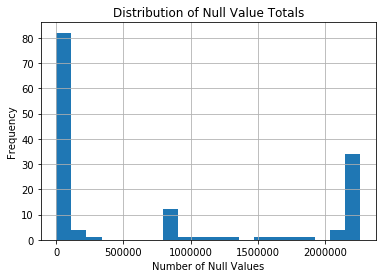

In [2]:
#check how many null values there are
original_data.isnull().sum().hist(bins=20)
plt.title('Distribution of Null Value Totals')
plt.xlabel('Number of Null Values')
plt.ylabel('Frequency')
plt.show()

it seems that most columns have no or very few null values, a few have values in the neighborhood of a million null values, while other columns are completely blank and entirely comprised of null balues. A good rule of thumb when dealing with null values in machine learning is to exclude any columns with over 40% missing data. Let's do that now

In [3]:
#Removing columns with many null values
entries=len(original_data.index)
percentile=.4
loan_data=original_data.dropna(thresh=int(percentile*entries),axis=1)


Now, the target variable for this analysis is Loan Status

In [4]:
loan_data.loan_status.value_counts()

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64

There are nine possible categories here, falling into three broad categories: Fully Paid, Current, and Charged Off. Our goal in this analysis is to predict which current loans are likely to default. We cannot use the fully paid values because...

In [5]:
loan_data=loan_data[loan_data.loan_status!='Fully Paid']
loan_data=loan_data[loan_data.loan_status!='Does not meet the credit policy. Status:Fully Paid']
loan_data.head(100)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method,debt_settlement_flag
0,2500,2500,2500.0,36 months,13.56,84.92,C,C1,Chef,10+ years,...,0.0,1.0,0.0,60124.0,16901.0,36500.0,18124.0,N,Cash,N
1,30000,30000,30000.0,60 months,18.94,777.23,D,D2,Postmaster,10+ years,...,0.0,1.0,0.0,372872.0,99468.0,15000.0,94072.0,N,Cash,N
2,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Administrative,6 years,...,0.0,0.0,0.0,136927.0,11749.0,13800.0,10000.0,N,Cash,N
3,4000,4000,4000.0,36 months,18.94,146.51,D,D2,IT Supervisor,10+ years,...,100.0,0.0,0.0,385183.0,36151.0,5000.0,44984.0,N,Cash,N
4,30000,30000,30000.0,60 months,16.14,731.78,C,C4,Mechanic,10+ years,...,0.0,0.0,0.0,157548.0,29674.0,9300.0,32332.0,N,Cash,N
5,5550,5550,5550.0,36 months,15.02,192.45,C,C3,Director COE,10+ years,...,60.0,0.0,0.0,831687.0,185378.0,65900.0,203159.0,N,Cash,N
6,2000,2000,2000.0,36 months,17.97,72.28,D,D1,Account Manager,4 years,...,NaN,0.0,0.0,854.0,854.0,0.0,0.0,N,Cash,N
7,6000,6000,6000.0,36 months,13.56,203.79,C,C1,Assistant Director,10+ years,...,85.7,0.0,0.0,117242.0,91535.0,33100.0,61742.0,N,DirectPay,N
8,5000,5000,5000.0,36 months,17.97,180.69,D,D1,Legal Assistant III,10+ years,...,60.0,0.0,0.0,57426.0,41882.0,21500.0,34626.0,N,Cash,N
9,6000,6000,6000.0,36 months,14.47,206.44,C,C2,NaN,< 1 year,...,26.3,0.0,0.0,477390.0,105911.0,98300.0,89600.0,N,Cash,N


In [6]:
loan_status_column=loan_data.loan_status


In [7]:
loan_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1216728 entries, 0 to 2260667
Data columns (total 103 columns):
loan_amnt                     int64
funded_amnt                   int64
funded_amnt_inv               float64
term                          object
int_rate                      float64
installment                   float64
grade                         object
sub_grade                     object
emp_title                     object
emp_length                    object
home_ownership                object
annual_inc                    float64
verification_status           object
issue_d                       object
loan_status                   object
pymnt_plan                    object
purpose                       object
title                         object
zip_code                      object
addr_state                    object
dti                           float64
delinq_2yrs                   float64
earliest_cr_line              object
inq_last_6mths                f

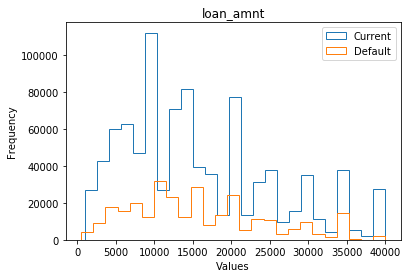

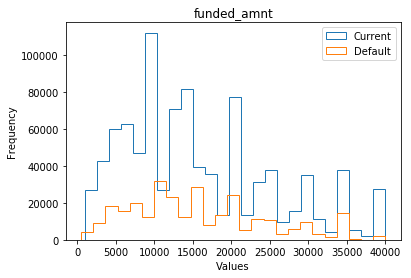

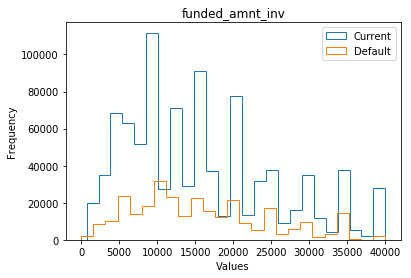

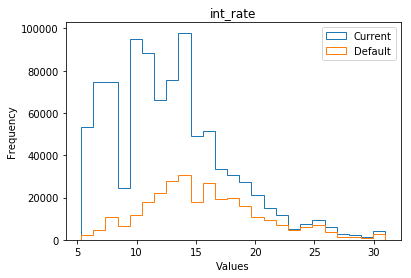

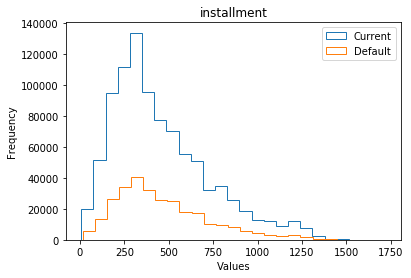

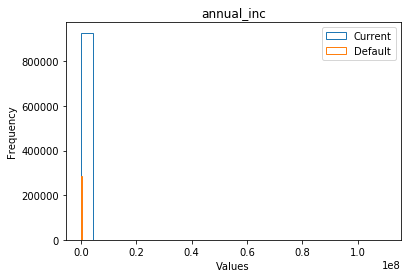

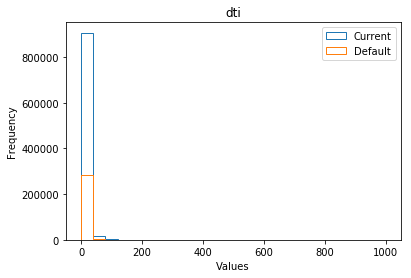

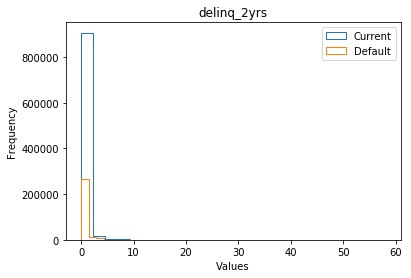

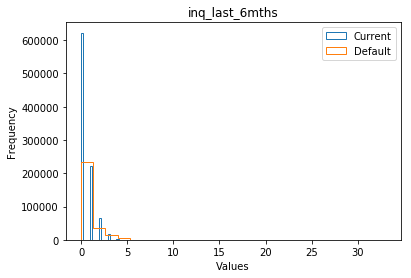

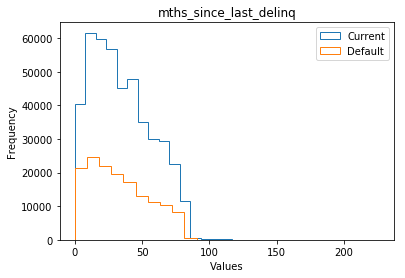

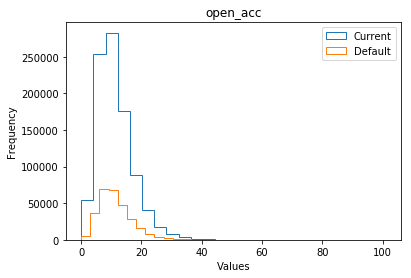

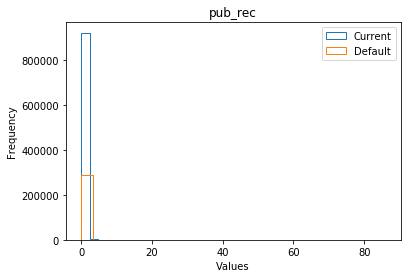

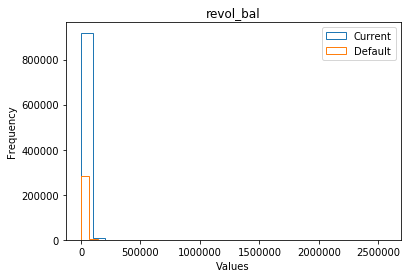

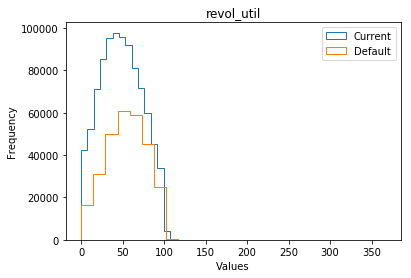

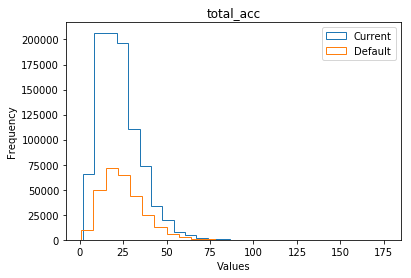

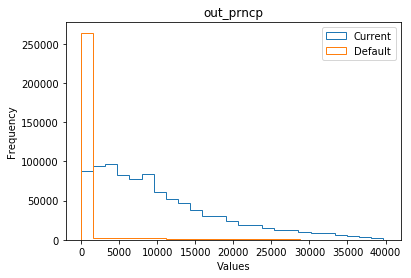

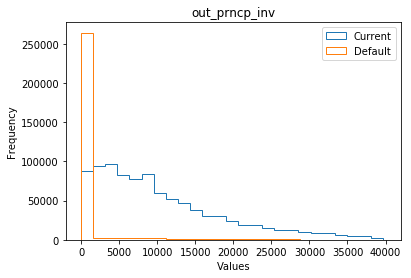

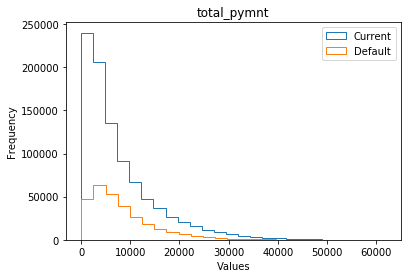

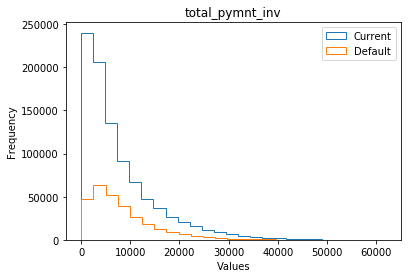

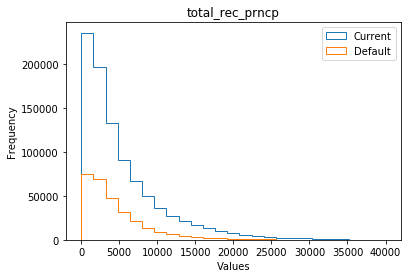

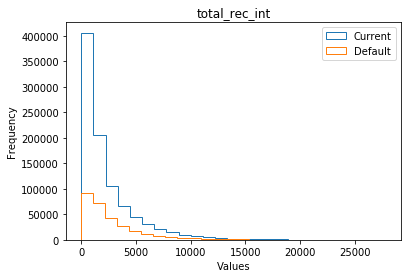

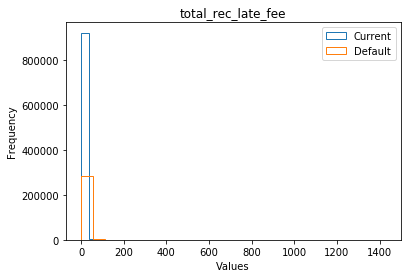

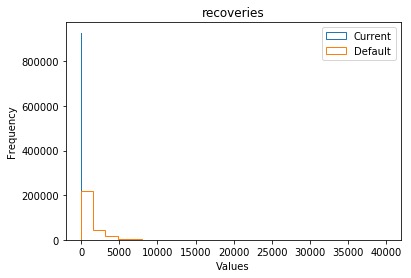

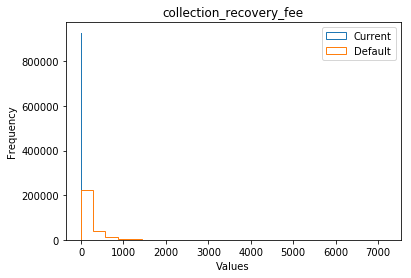

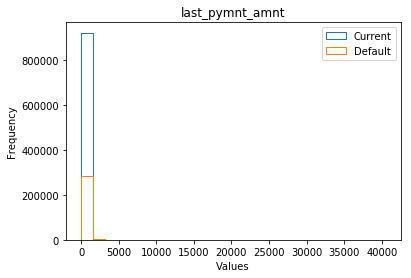

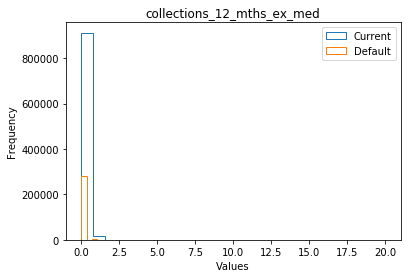

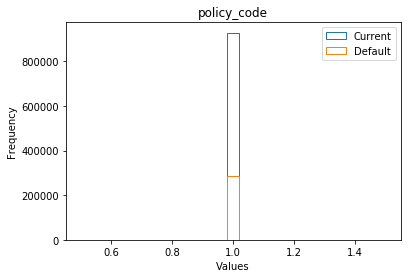

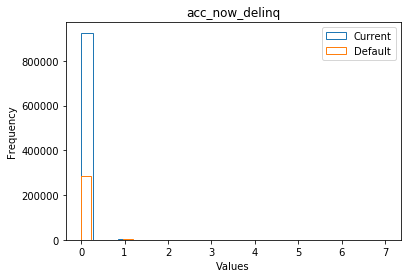

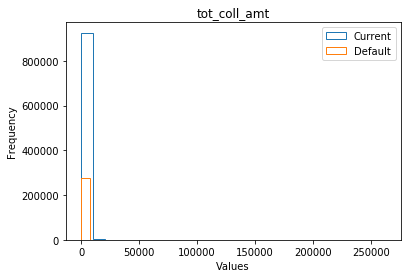

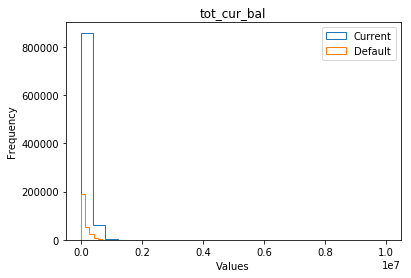

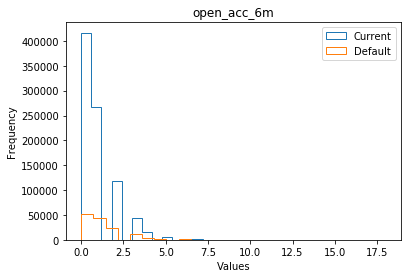

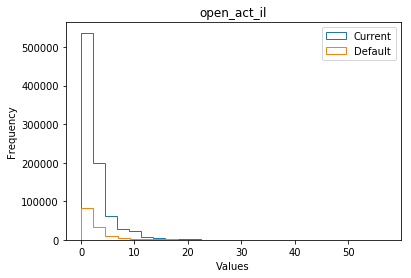

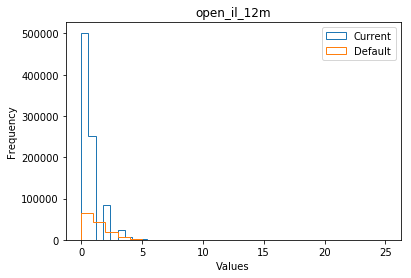

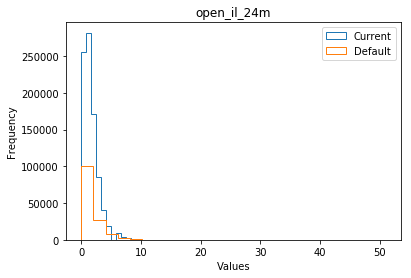

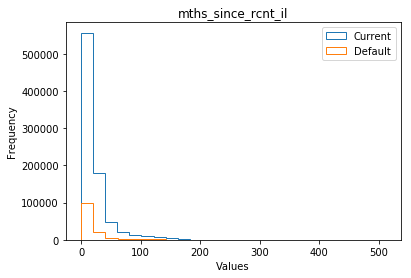

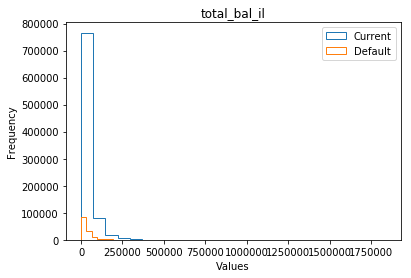

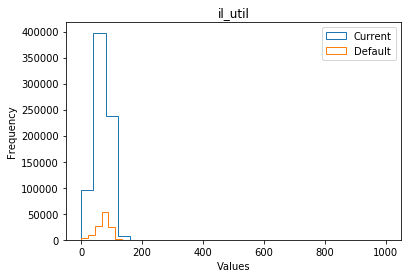

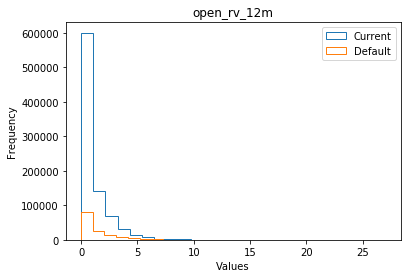

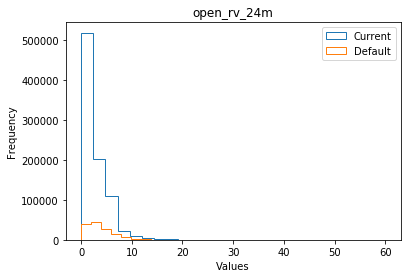

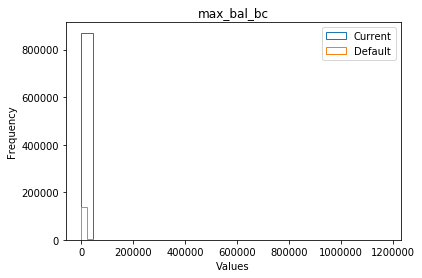

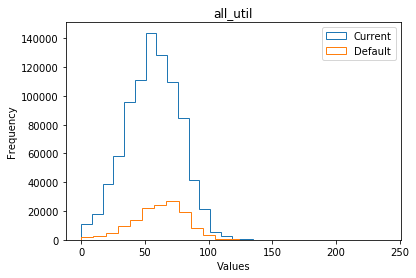

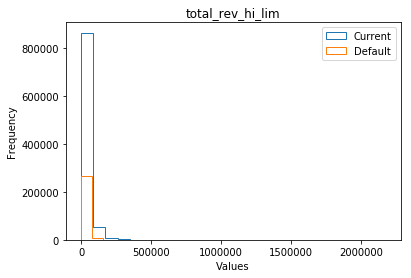

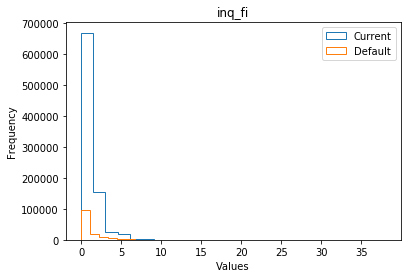

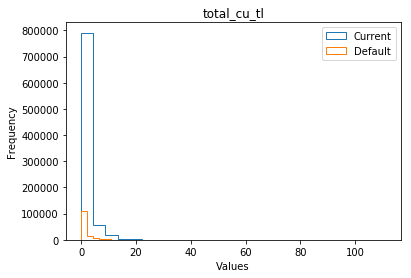

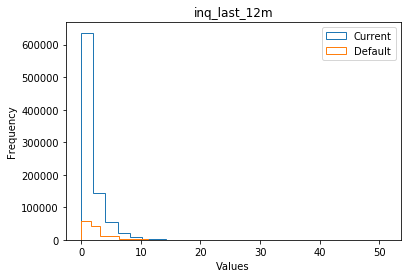

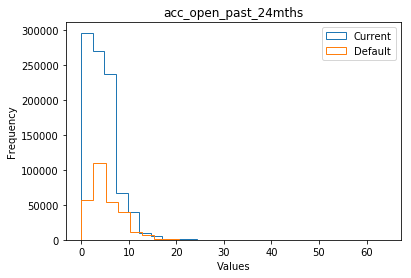

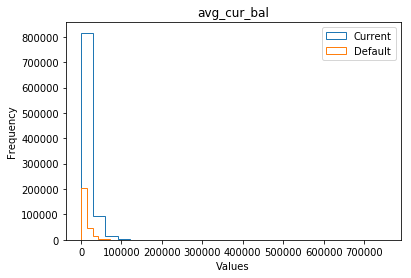

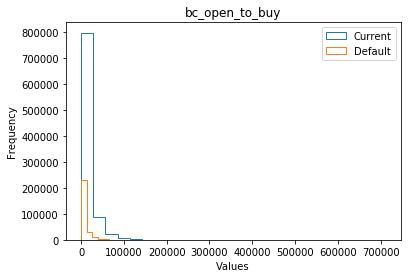

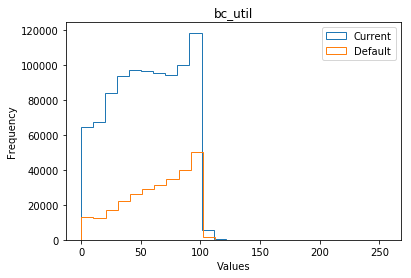

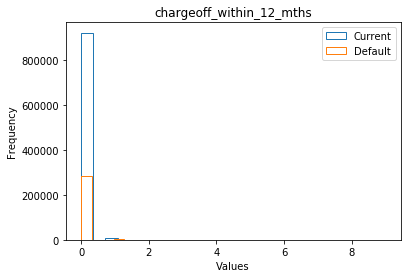

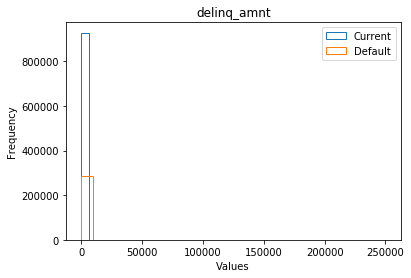

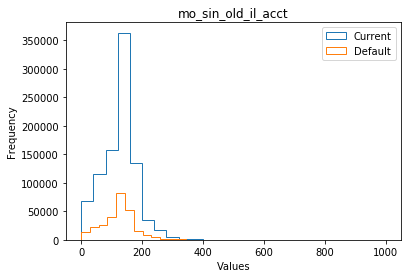

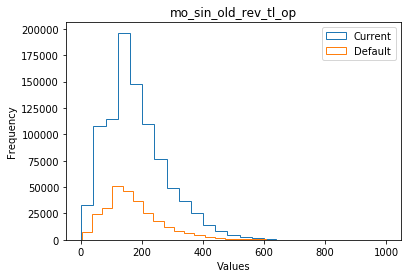

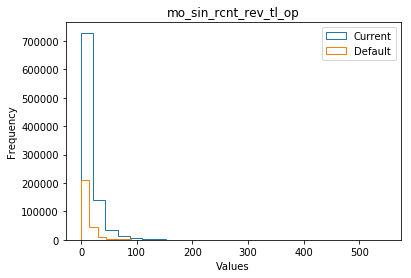

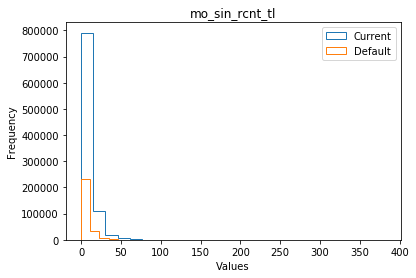

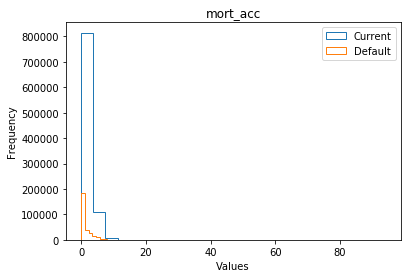

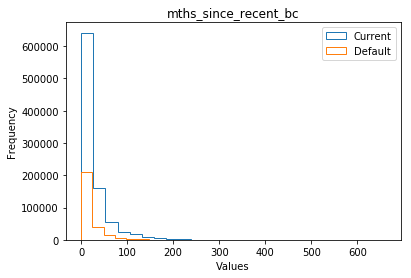

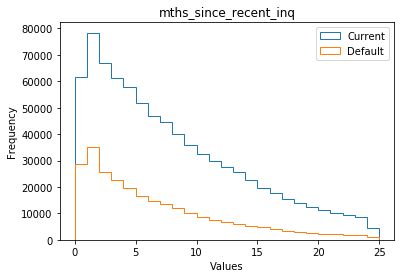

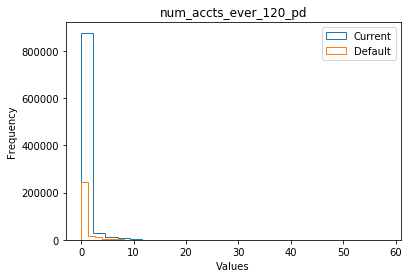

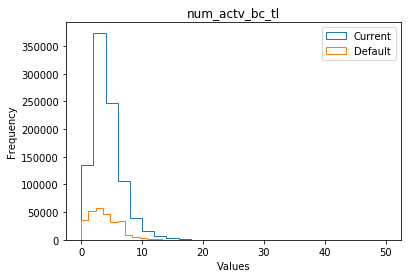

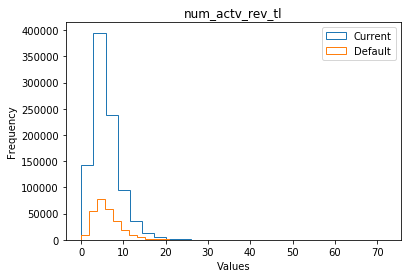

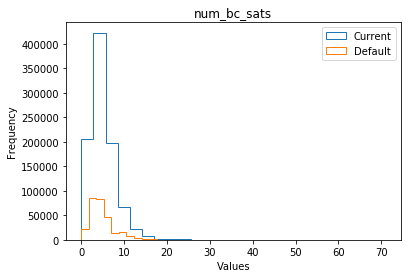

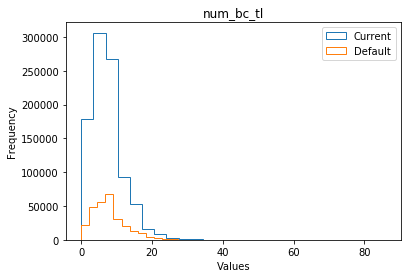

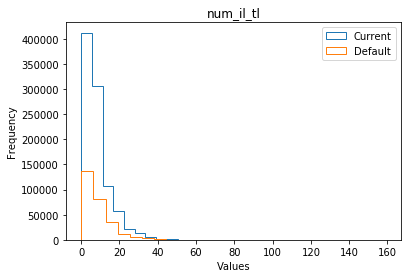

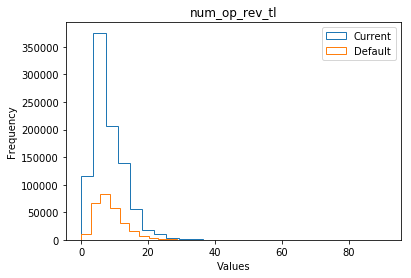

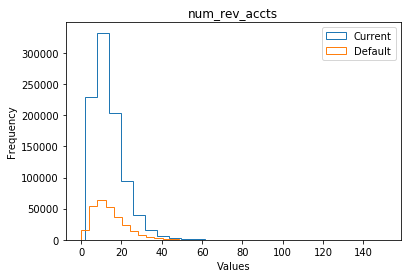

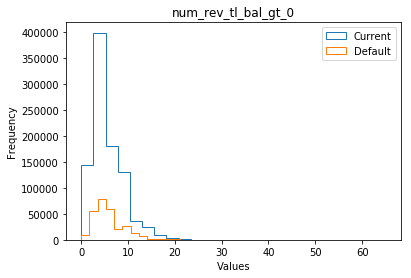

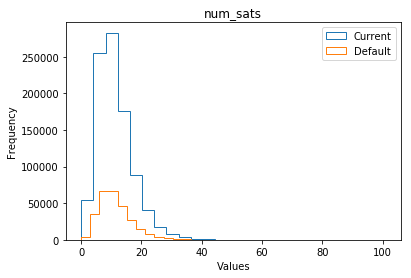

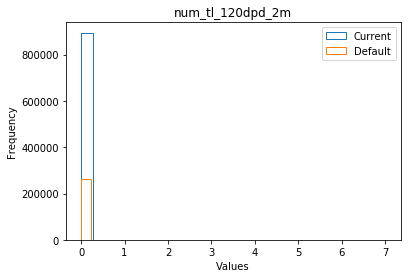

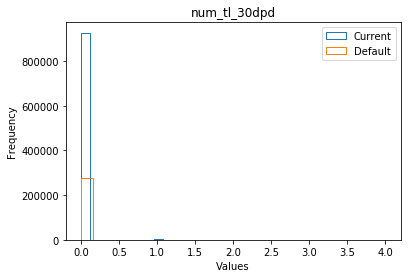

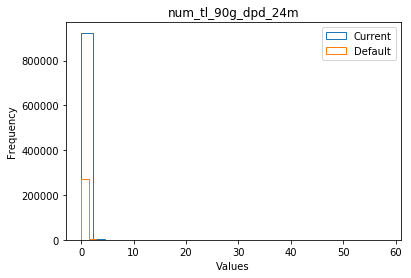

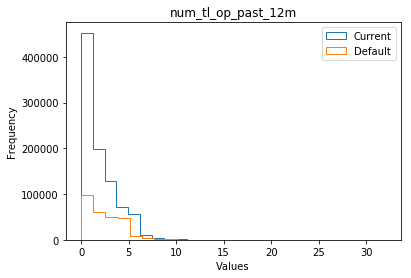

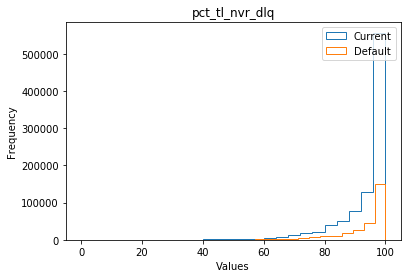

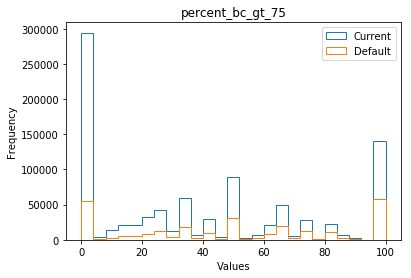

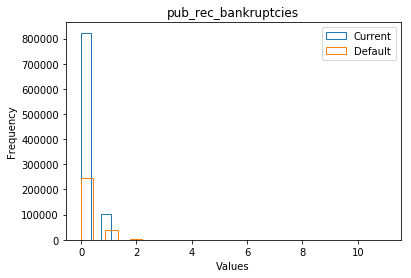

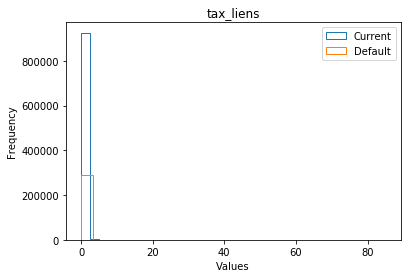

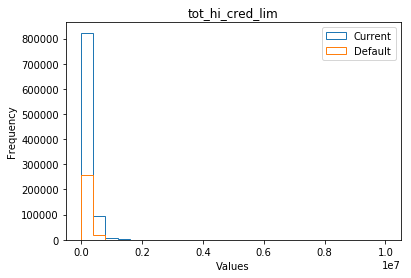

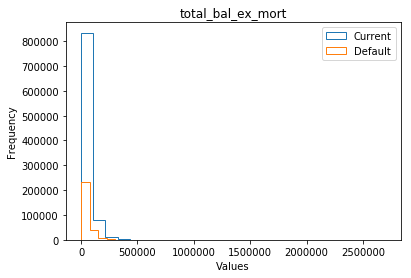

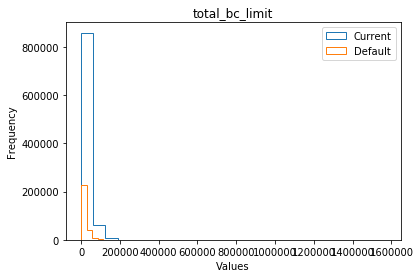

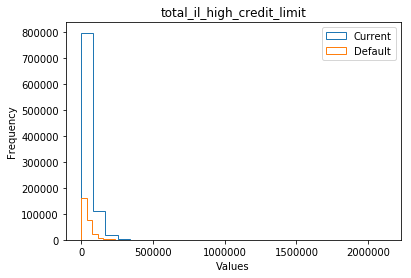

In [8]:
for column in loan_data.columns:
    if(loan_data[column].dtype == np.float64 or loan_data[column].dtype == np.int64):
        #loan_data[y].plot(kind='hist',histtype='step',density=True, bins=25)
        loan_data[(loan_status_column=='Current')|(loan_status_column=='In Grace Period')][column].plot(kind='hist',bins=25, histtype='step')
        loan_data[((loan_status_column!='Current')&(loan_status_column!='In Grace Period'))][column].plot(kind='hist',bins=25, histtype='step')
        plt.legend(['Current','Default'])
        plt.title(str(column))
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.show()


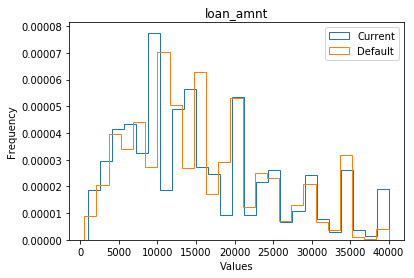

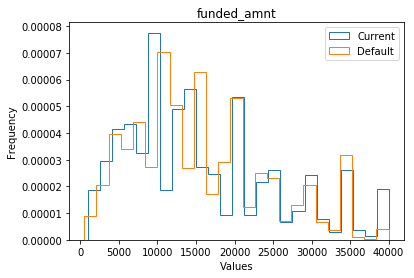

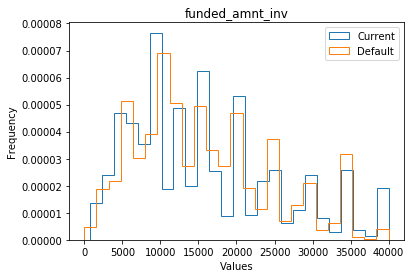

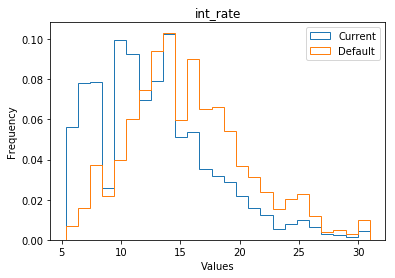

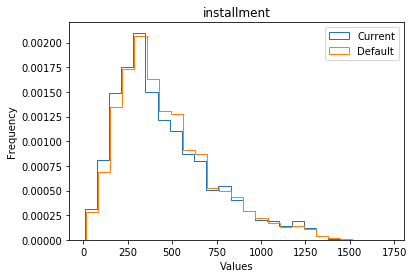

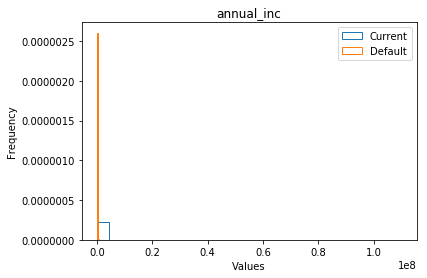

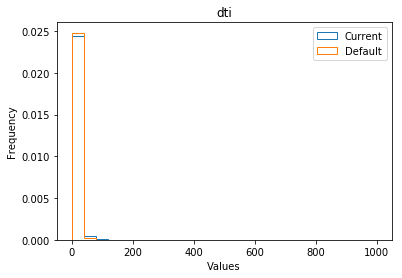

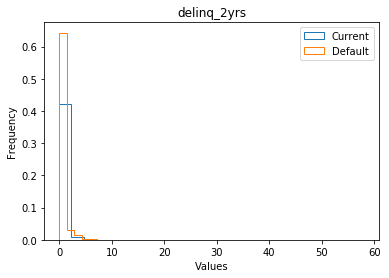

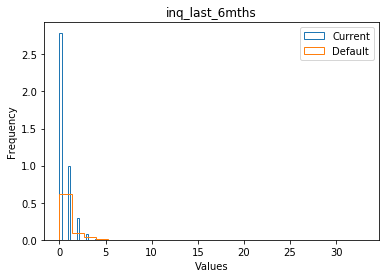

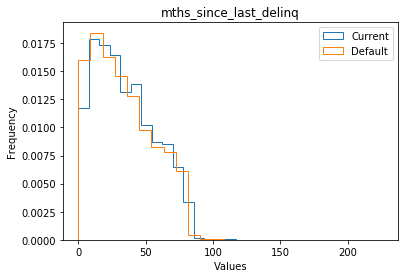

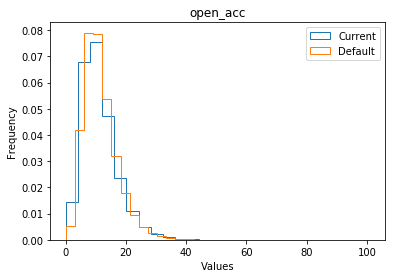

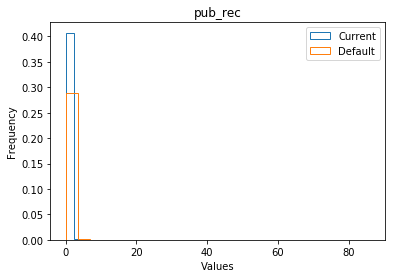

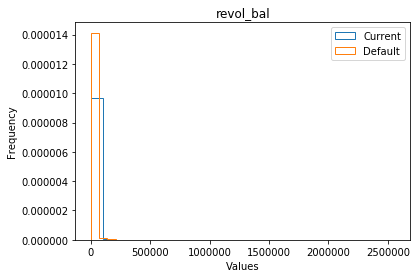

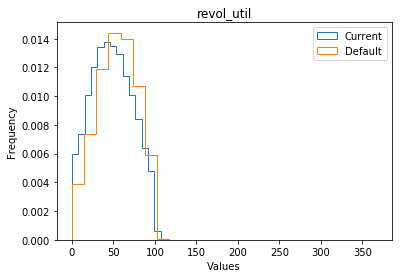

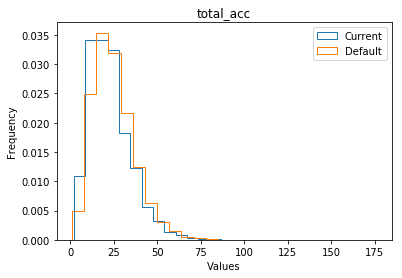

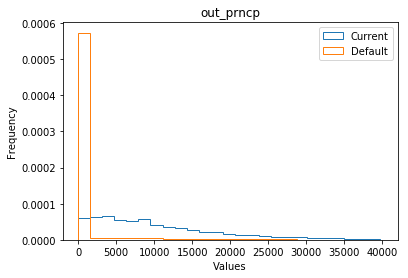

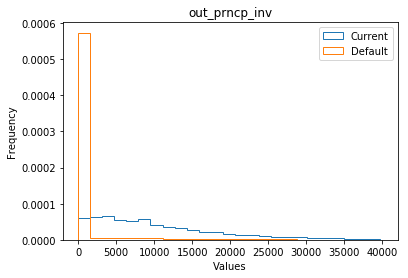

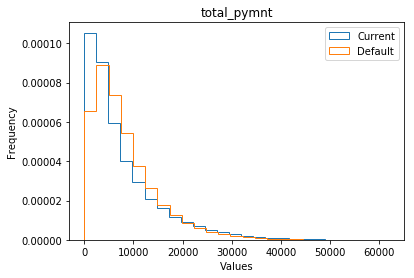

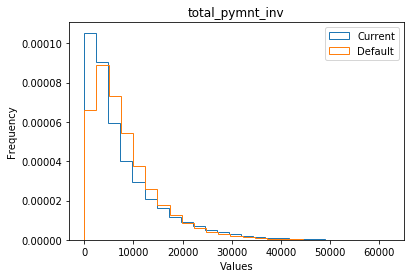

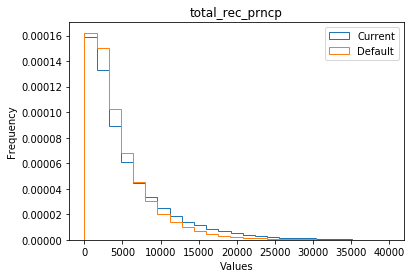

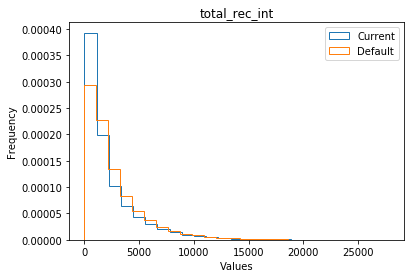

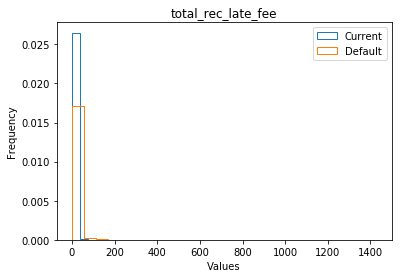

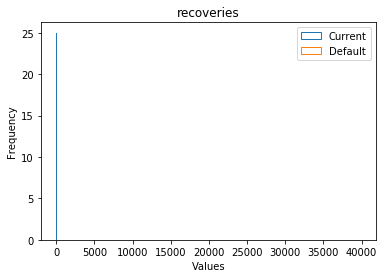

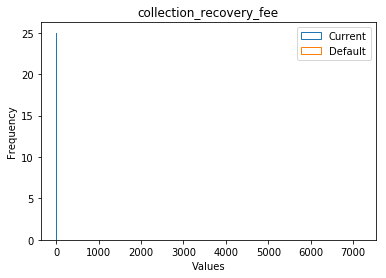

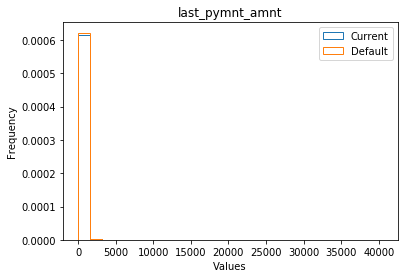

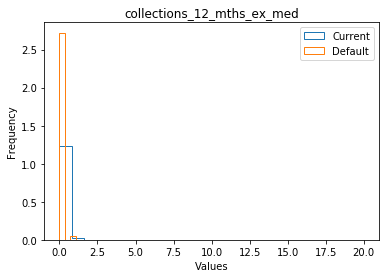

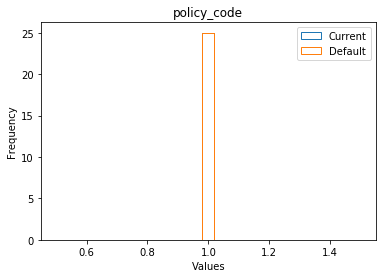

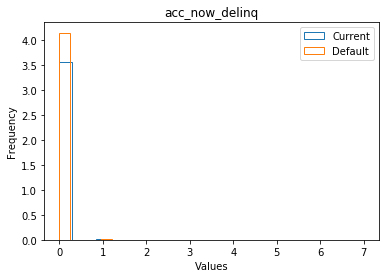

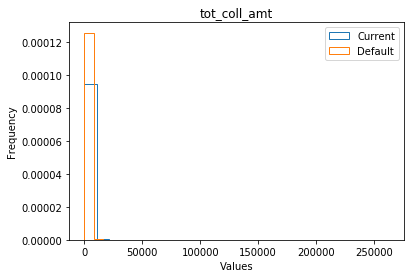

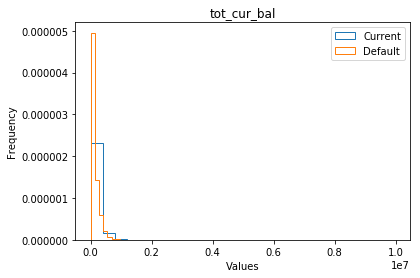

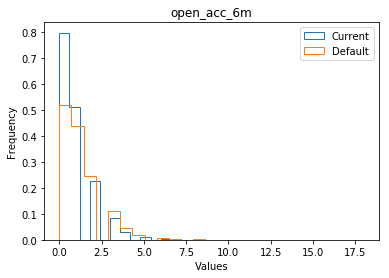

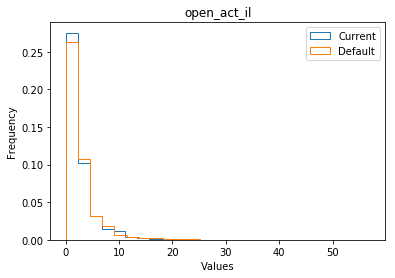

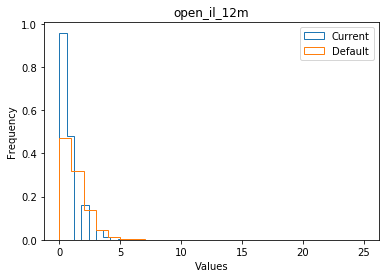

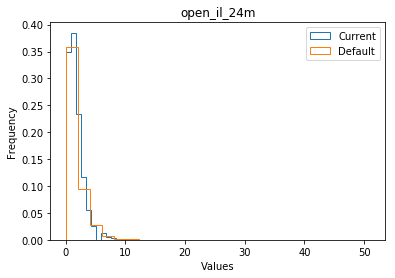

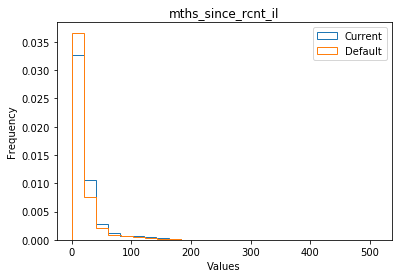

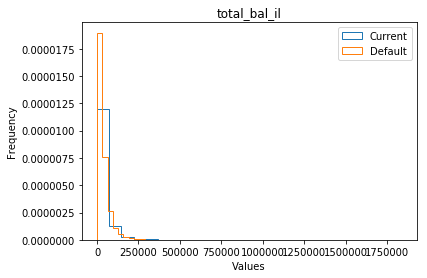

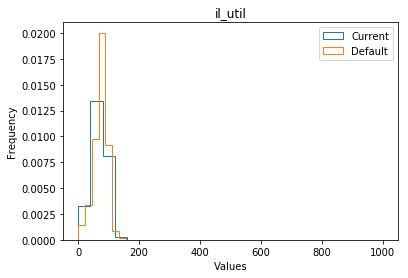

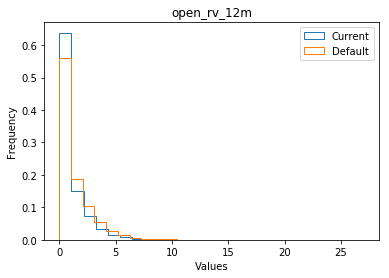

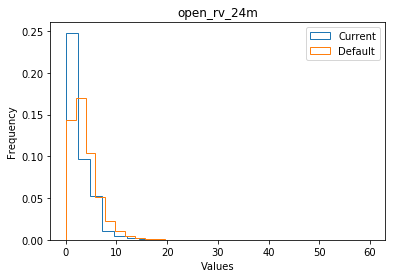

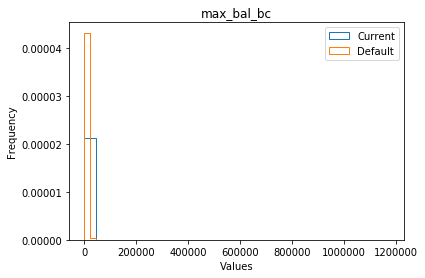

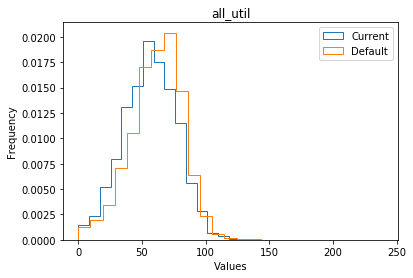

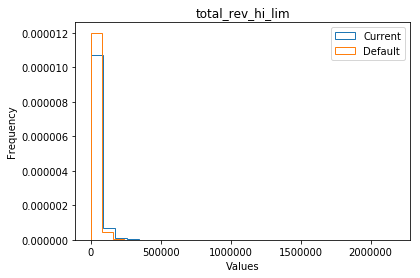

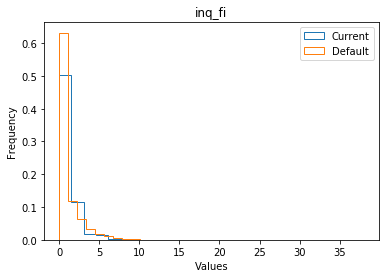

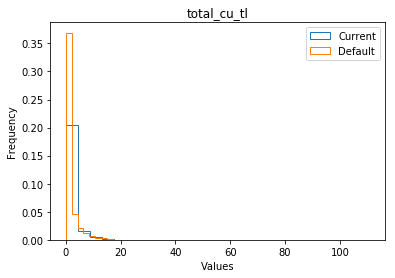

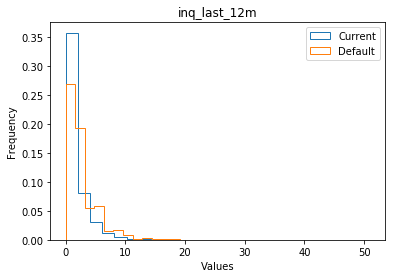

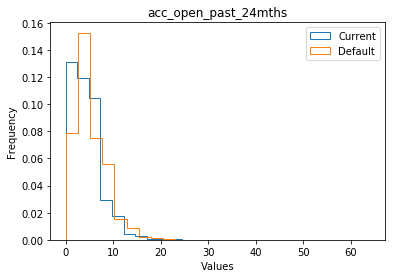

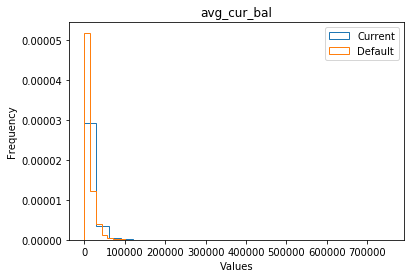

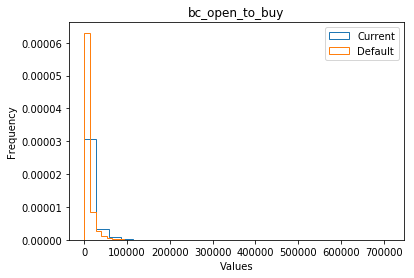

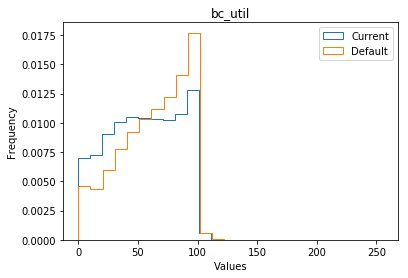

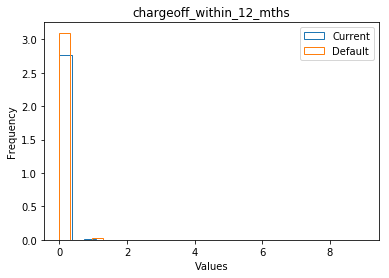

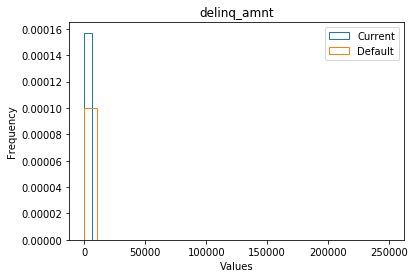

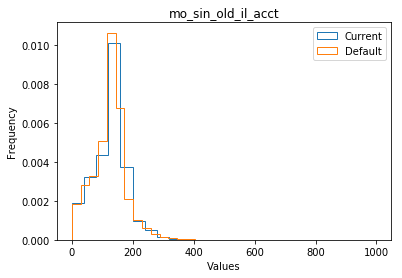

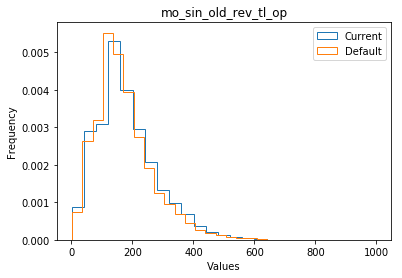

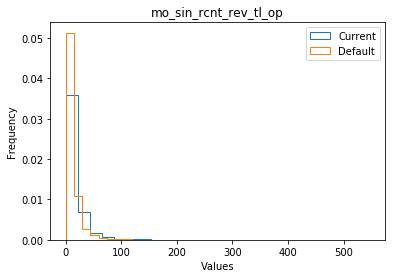

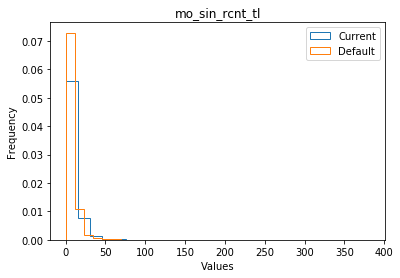

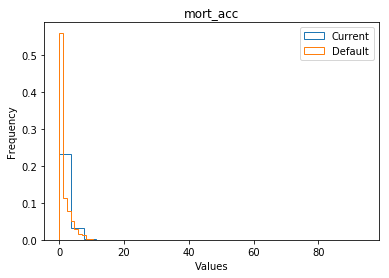

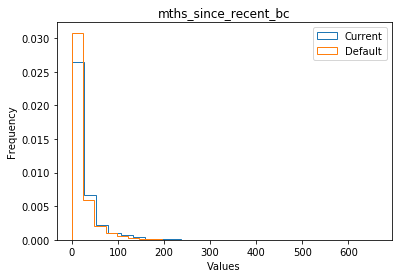

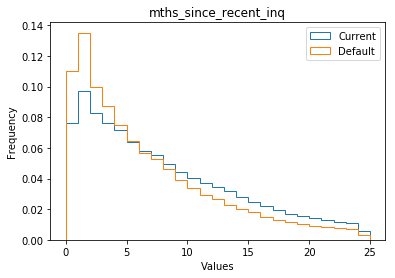

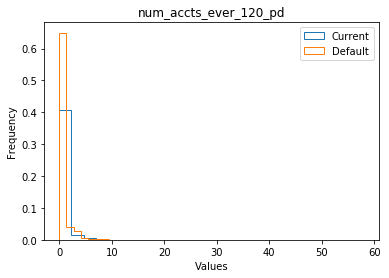

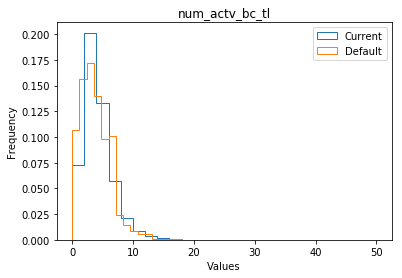

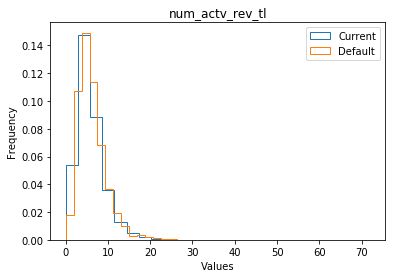

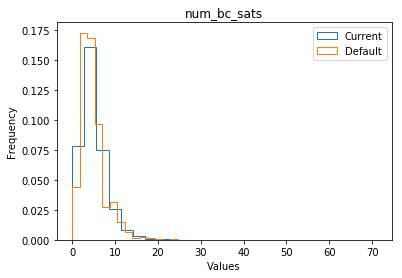

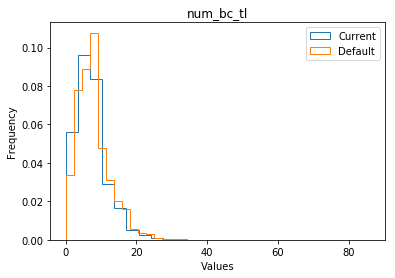

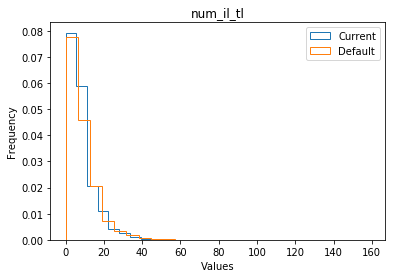

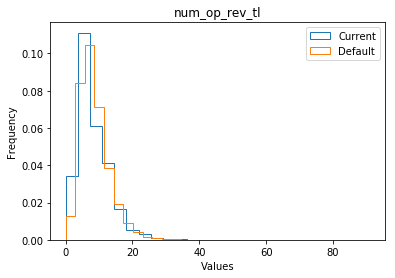

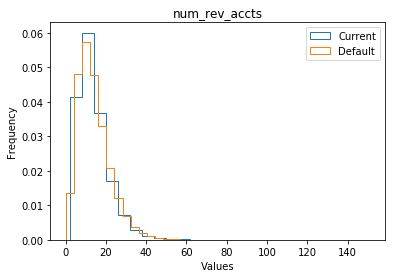

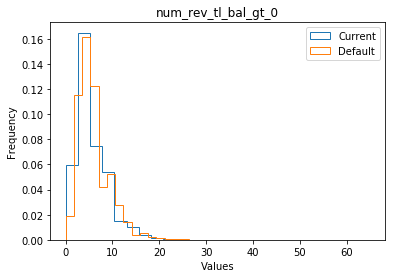

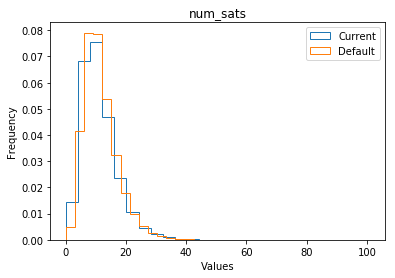

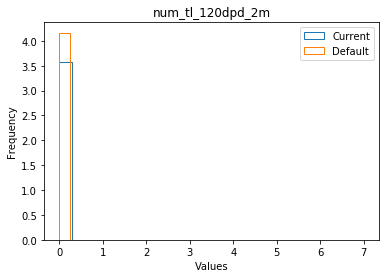

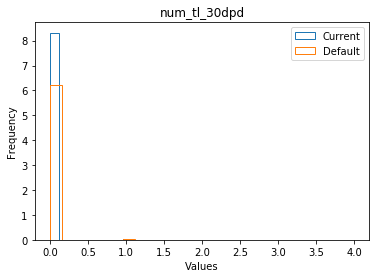

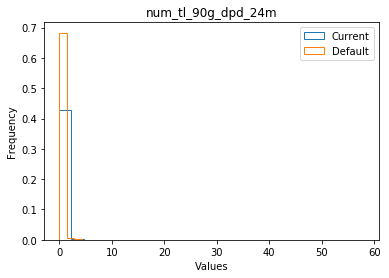

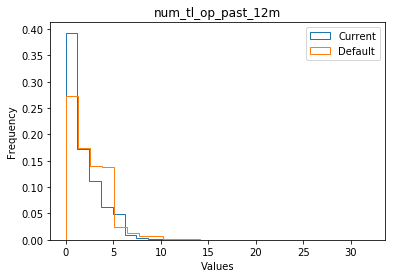

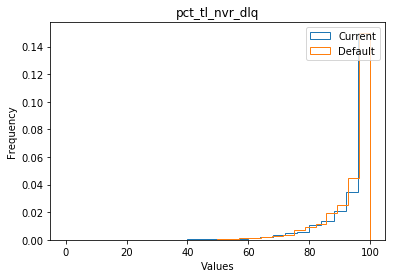

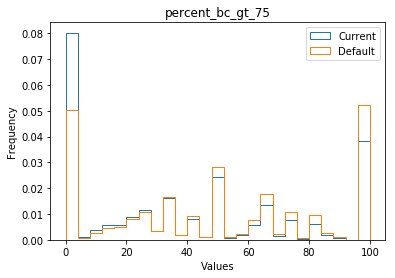

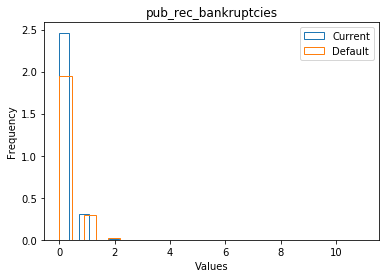

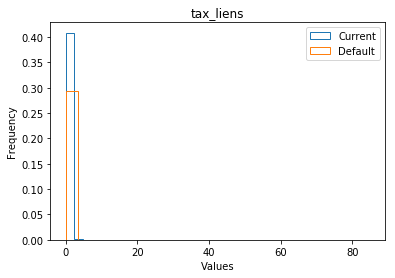

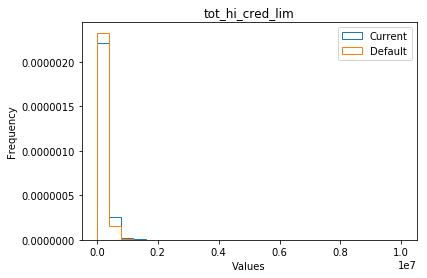

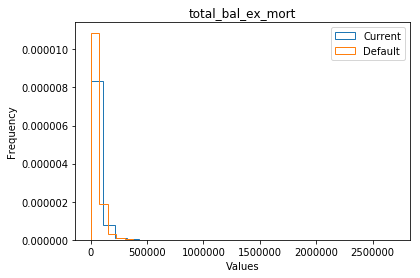

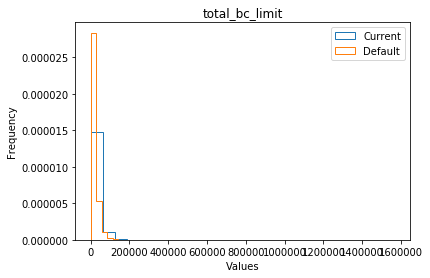

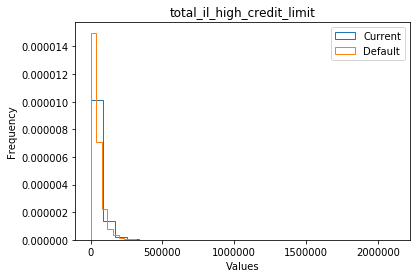

In [9]:
for column in loan_data.columns:
    if(loan_data[column].dtype == np.float64 or loan_data[column].dtype == np.int64):
        #loan_data[y].plot(kind='hist',histtype='step',density=True, bins=25)
        loan_data[(loan_status_column=='Current')|(loan_status_column=='In Grace Period')][column].plot(kind='hist',bins=25, histtype='step',density=True)
        loan_data[((loan_status_column!='Current')&(loan_status_column!='In Grace Period'))][column].plot(kind='hist',bins=25, histtype='step',density=True)
        plt.legend(['Current','Default'])
        plt.title(str(column))
        plt.xlabel('Values')
        plt.ylabel('Frequency')
        plt.show()

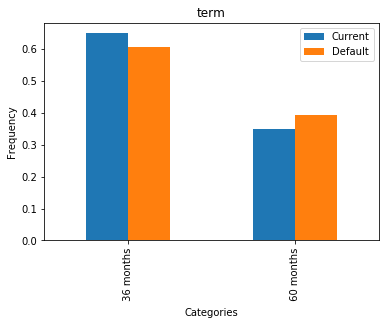

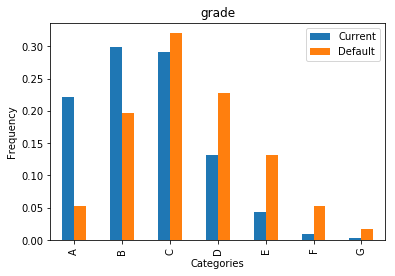

sub_grade cannot be plotted due too too many possible values
emp_title cannot be plotted due too too many possible values


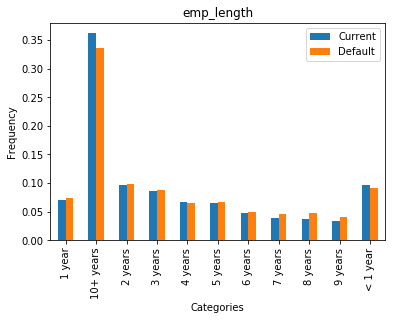

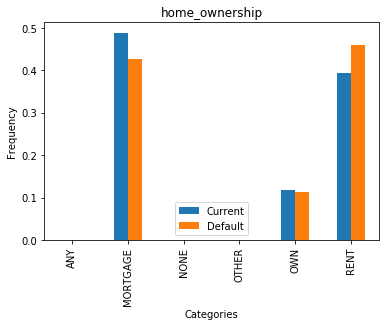

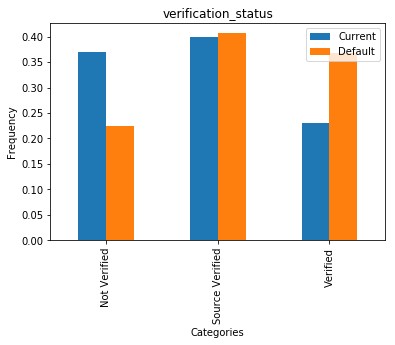

issue_d cannot be plotted due too too many possible values


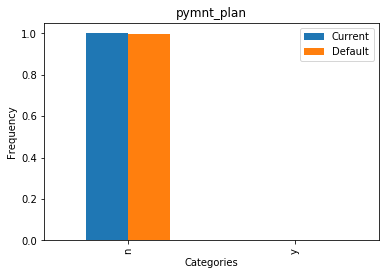

purpose cannot be plotted due too too many possible values
title cannot be plotted due too too many possible values
zip_code cannot be plotted due too too many possible values
addr_state cannot be plotted due too too many possible values
earliest_cr_line cannot be plotted due too too many possible values


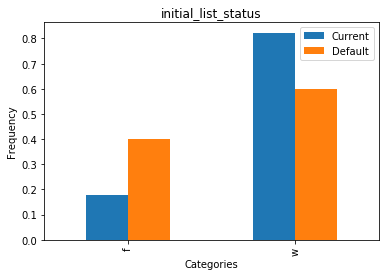

last_pymnt_d cannot be plotted due too too many possible values
next_pymnt_d cannot be plotted due too too many possible values
last_credit_pull_d cannot be plotted due too too many possible values


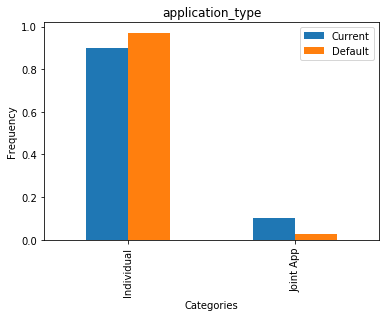

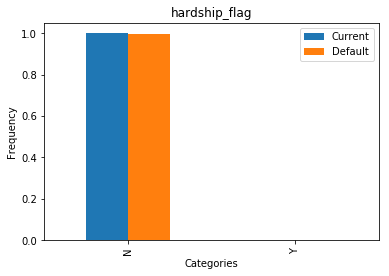

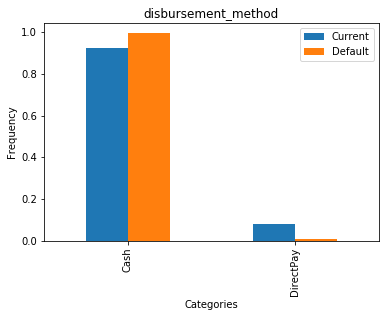

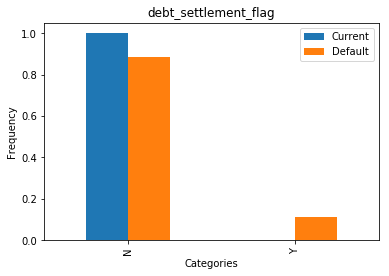

In [10]:

for column in loan_data.columns:
    if((loan_data[column].dtype == 'O')&(column!='loan_status')):
        if(loan_data[column].value_counts().size<12):
            temp=pd.DataFrame()
            temp.loc[:,'status']=loan_status_column.apply(lambda x: 0 if x=='Current'or x=='In Grace Period' else 1)
            temp.loc[:,column]=loan_data[column]
            temp.loc[:,'number']=range(loan_status_column.size)
            temp=temp.groupby([column,'status']).agg('count').unstack(level=1)
            temp.columns=temp.columns.droplevel()
            temp.iloc[:,0]=temp.iloc[:,0]/temp[0].sum()
            temp.iloc[:,1]=temp.iloc[:,1]/temp[1].sum()
            temp.plot(kind='bar')
            plt.legend(['Current','Default'])
            plt.xlabel('Categories')
            plt.ylabel('Frequency')
            plt.title(str(column))
            plt.show()
        else:
            print(str(column)+' cannot be plotted due too too many possible values')
    
            

In [11]:
columns_to_drop=['emp_title','title','pymnt_plan','zip_code','out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv','total_rec_prncp', 'total_rec_int', 'total_rec_late_fee','recoveries', 'collection_recovery_fee', 'last_pymnt_d','last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d','issue_d','earliest_cr_line']

In [12]:
loan_data=loan_data.drop(columns_to_drop,axis=1)

In [13]:
loan_data.loan_status.value_counts()

Current                                                919695
Charged Off                                            261655
Late (31-120 days)                                      21897
In Grace Period                                          8952
Late (16-30 days)                                        3737
Does not meet the credit policy. Status:Charged Off       761
Default                                                    31
Name: loan_status, dtype: int64

In [14]:
sample=loan_data.sample(n=10000)
y=sample.loan_status
y=y.apply(lambda x: 0 if x=='Current'or x=='In Grace Period' else 1)
loan_data=sample.drop(['loan_status'],axis=1)
dummied_loan_data=pd.get_dummies(loan_data,drop_first=True)


In [15]:
from sklearn.preprocessing import normalize,PowerTransformer
X_fillna_median=dummied_loan_data.fillna(dummied_loan_data.median())
X_fillna_mean=dummied_loan_data.fillna(dummied_loan_data.mean())
X_normed_mean=normalize(X_fillna_mean)
pt=PowerTransformer()
X_yeojohn_mean=pt.fit_transform(X_fillna_mean)
                       
                       
                       
                        
                       


/Users/neiloza/miniconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:2798: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
rf=RandomForestClassifier()
lr=LogisticRegression()
gnb=GaussianNB()
svc=SVC(probability=True)




In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve as prc,f1_score, recall_score, precision_score, roc_auc_score,roc_curve,accuracy_score

In [18]:
def evaluate_model2(X,y, model):
    func_X_train,func_X_test,func_y_train, func_y_test=train_test_split(X,y,test_size=.25,random_state=42)
    model.fit(func_X_train,func_y_train)
    predict_probas=model.predict_proba(func_X_test)
    plot_roc_curve(np.array(func_y_test),predict_probas)
    plot_precision_recall(np.array(func_y_test),predict_probas)
    plot_lift_curve(np.array(func_y_test),predict_probas)
    plot_cumulative_gain(np.array(func_y_test),predict_probas)



In [19]:
from scikitplot.metrics import plot_cumulative_gain, plot_lift_curve, plot_precision_recall, plot_roc_curve

In [20]:
def evaluate_model(X,y, model):
    #perform train-test split
    func_X_train,func_X_test,func_y_train, func_y_test=train_test_split(X,y,test_size=.25,random_state=42)
    #train the model
    model.fit(func_X_train,func_y_train)
    #Create predicted probability distributions
    prob_of_1=model.predict_proba(func_X_test)[:,1]
    prob_truth=pd.concat([pd.DataFrame(prob_of_1),pd.DataFrame(func_y_test).reset_index().loan_status],axis=1)
    prob_truth.columns=['Probability','Default']
    prob_current=prob_truth[prob_truth.Default==0].Probability
    prob_default=prob_truth[prob_truth.Default==1].Probability
    prob_current.plot.hist(alpha=.5,bins=10)
    prob_default.plot.hist(alpha=.5,bins=10)
    plt.xlim(0,1)
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Prediction Distributions for Default and Current Loans')
    plt.legend(['Current','Default'])
    plt.show()
    #Precision recall curves
    precision, recall, threshold=prc(y_true=func_y_test,probas_pred=prob_of_1)
    threshold=np.insert(threshold, 0,0)
    f1=np.multiply(precision,recall)/np.add(precision,recall)*2
    plt.close('all')
    plt.plot(threshold,precision)
    plt.plot(threshold,recall)
    plt.plot(threshold,f1)
    plt.legend(['Precision','Recall','f1'])
    plt.xlabel('Threshold')
    plt.ylabel('Metric')
    plt.title('Precision Recall Curve')
    plt.show()
    #compute performance metrics
    print('the Precision is '+str(precision_score(y_true=func_y_test,y_pred=model.predict(func_X_test))))
    print('the Recall is '+str(recall_score(y_true=func_y_test,y_pred=model.predict(func_X_test))))
    print('the f1 score is '+str(f1_score(func_y_test,model.predict(func_X_test))))
    print('the roc-auc score is '+str(roc_auc_score(func_y_test,prob_of_1)))
    print('the accuracy score is '+str(accuracy_score(func_y_test,model.predict(func_X_test))))
    print('The number of loans predicted to default is '+str(model.predict(func_X_test).sum())+' out of a test size of '+str(len(func_y_test.index)))
    #create ROC curve
    fpr, tpr, threshold2=roc_curve(func_y_test,prob_of_1)
    plt.plot(fpr,tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(' ROC Curve')
    plt.show()
    #create gains chart and lift curve
    plt.close('all')
    predict_probas=model.predict_proba(func_X_test)
    plot_lift_curve(np.array(func_y_test),predict_probas)
    plt.show()
    plot_cumulative_gain(np.array(func_y_test),predict_probas)
    plt.show()
    
    

/Users/neiloza/miniconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


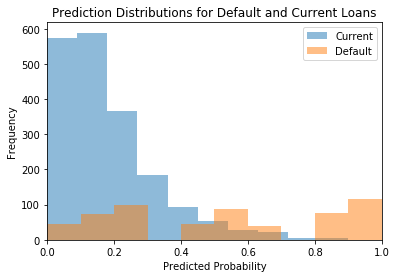

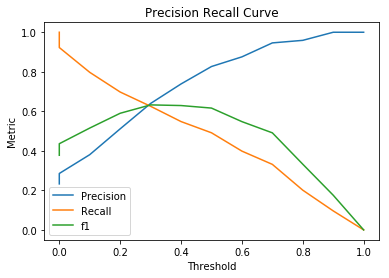

the Precision is 0.8265895953757225
the Recall is 0.49140893470790376
the f1 score is 0.6163793103448275
the roc-auc score is 0.81210068119354
the accuracy score is 0.8576
The number of loans predicted to default is 346 out of a test size of 2500


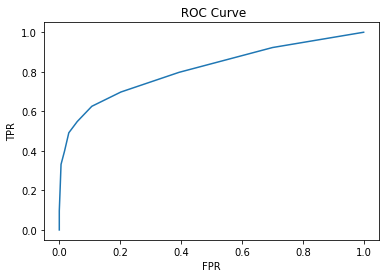

/Users/neiloza/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


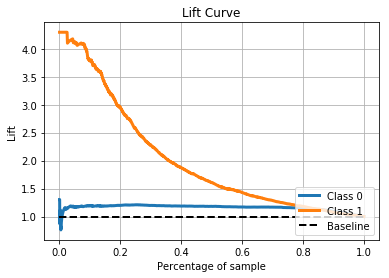

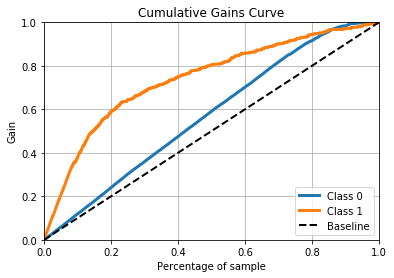

In [21]:
evaluate_model(X_fillna_median,y,rf)

In [22]:
evaluate_model(X,y,lr)

NameError: name 'X' is not defined

/Users/neiloza/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/neiloza/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


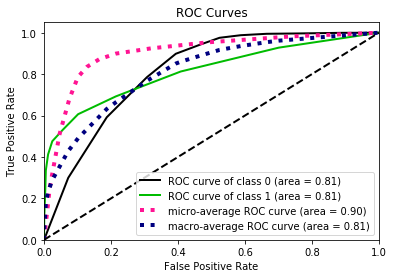

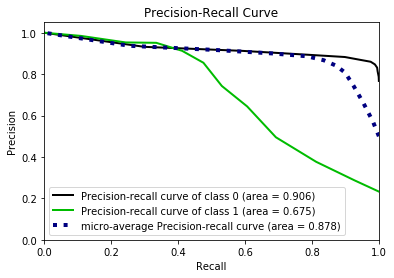

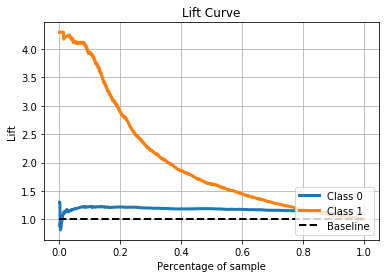

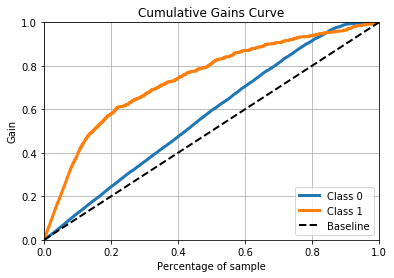

In [23]:
evaluate_model2(X_fillna_median,y,rf)

/Users/neiloza/miniconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


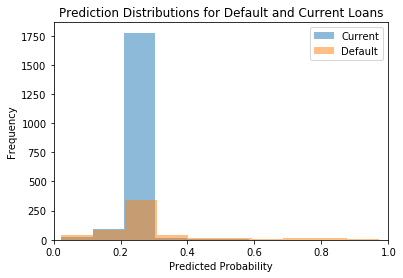

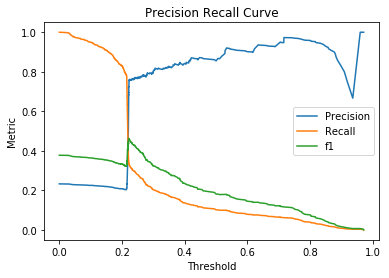

/Users/neiloza/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


the Precision is 0.0
the Recall is 0.0


/Users/neiloza/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


the f1 score is 0.0
the roc-auc score is 0.5981334365336172
the accuracy score is 0.7672
The number of loans predicted to default is 0 out of a test size of 2500


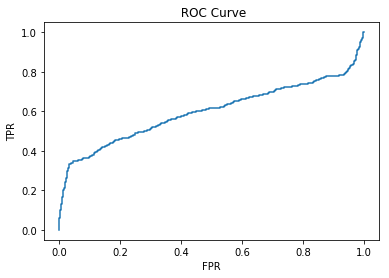

/Users/neiloza/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


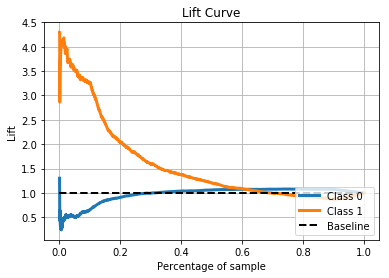

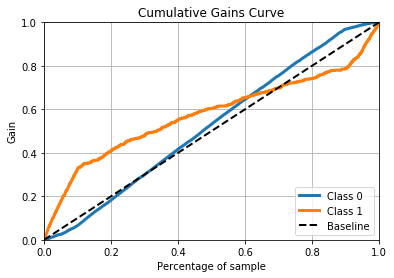

In [24]:
evaluate_model(X_normed_mean,y,svc)

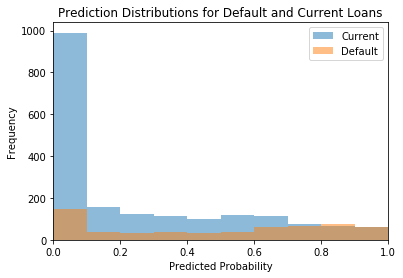

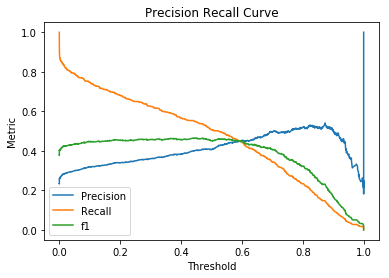

the Precision is 0.405777166437414
the Recall is 0.506872852233677
the f1 score is 0.4507257448433919
the roc-auc score is 0.6885953832206372
the accuracy score is 0.7124
The number of loans predicted to default is 727 out of a test size of 2500


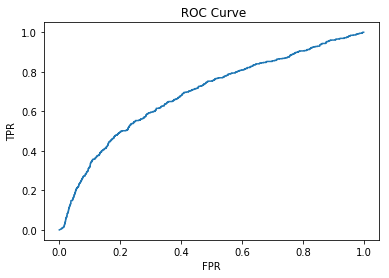

/Users/neiloza/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


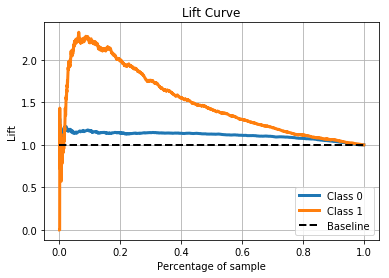

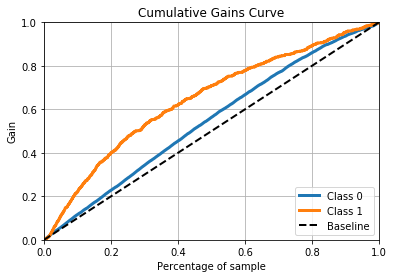

In [25]:
evaluate_model(X_fillna_mean,y,gnb)

In [26]:
from sklearn.model_selection import GridSearchCV
def tune_hyperparameters(X,y,params, model):
    gcv=GridSearchCV(model,params,cv=5,scoring='recall')
    func_X_train,func_X_test,func_y_train, func_y_test=train_test_split(X,y,test_size=.25,random_state=42)
    gcv.fit(func_X_train,func_y_train)
    print("best params are "+ str(gcv.best_params_))
    print("best score is "+ str(gcv.best_score_))






In [27]:
rf_params={'n_estimators':[100],'max_depth':[25,30,35],'max_features':[.30,.35,.40]}
tune_hyperparameters(X_fillna_median,y,rf_params,rf)

best params are {'max_depth': 25, 'max_features': 0.3, 'n_estimators': 100}
best score is 0.5049377025053364


best params are {'var_smoothing': 0.001}
best score is 0.7896509886529605


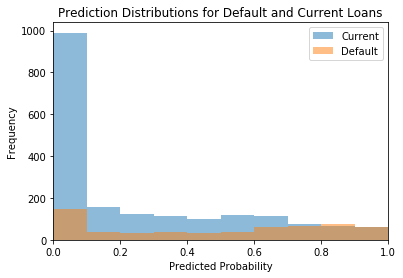

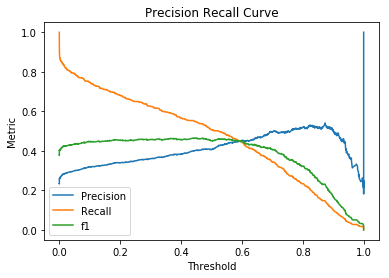

the Precision is 0.405777166437414
the Recall is 0.506872852233677
the f1 score is 0.4507257448433919
the roc-auc score is 0.6885953832206372
the accuracy score is 0.7124
The number of loans predicted to default is 727 out of a test size of 2500


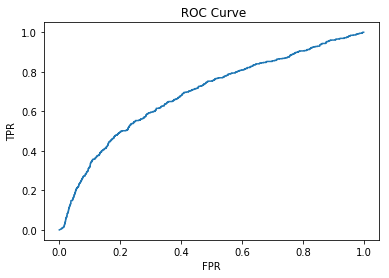

/Users/neiloza/miniconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


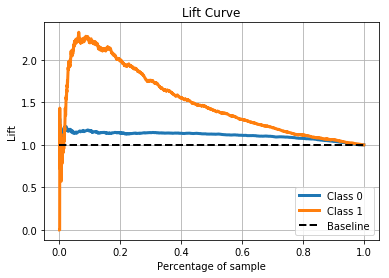

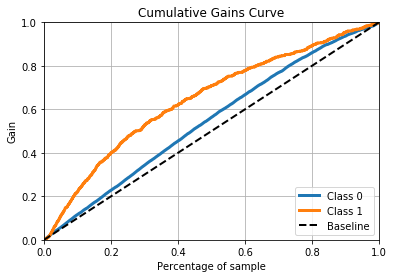

In [28]:
gnb_params={'var_smoothing':[.001,.01,.1,1,2]}
tune_hyperparameters(X_fillna_mean,y,gnb_params,gnb)
evaluate_model(X_fillna_mean,y,gnb)

In [29]:
log_params={'penalty':['l1','l2'],'C':[.1,.5,1,2,3]}
tune_hyperparameters(mean_X_train,mean_y_train,log_params,lr)

NameError: name 'mean_X_train' is not defined

In [ ]:
lr=LogisticRegression(C=2,penalty='l1')
evaluate_model(X_fillna_mean,y,lr)

In [ ]:
gnb=GaussianNB(var_smoothing=.0001)
evaluate_model(X_fillna_mean,y,gnb)